We are interested in solving the Poisson equation, which has the format of 

$\frac{d^2u}{dx^2} = -\sin(x) , \quad x \in [-\pi, \pi]$

with the following BC:

$u(-\pi) = u(\pi) = 0\$

For this equation, the loss function should represent the residuals of the equation, i.e., the discrepancy between the left-hand side and right-hand side of the equation for each point in the domain.

Let's define the loss function in PyTorch to properly account for this, where $u^*$ is the predicted data by the PINN :

$\text{PDE Loss} = \left\| \frac{d^2u^*}{dx^2} + \sin(x) \right\|^2$

$\text{BC Loss} = \left\| (u^*(-\pi) + u^*(\pi))  - (u(-\pi) + u(\pi))  \right\|^2$

Let's implement that using PyTorch

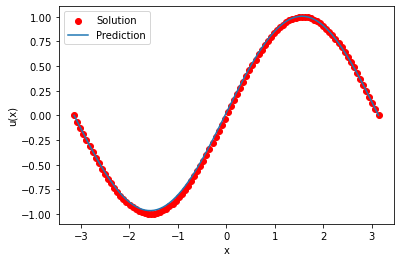

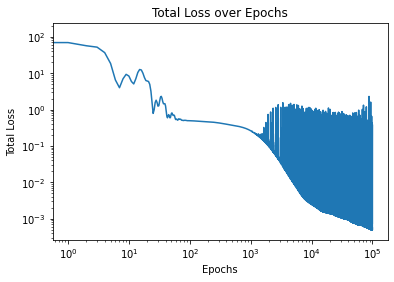

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define Neural Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate Data 
N = 100
x_data = torch.linspace(-np.pi, np.pi, N).view(-1, 1)
x_data.requires_grad = True  # Set requires_grad to True for differentiation


# Boundary conditions
boundary_points = torch.Tensor([[-np.pi], [np.pi]])
boundary_values = torch.zeros(2, 1)

# Create Model and Optimizer
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# To store total_loss for each epoch
loss_list = []

# Training Loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_data)
    
    # Calculate first and second derivative
    first_derivative, = torch.autograd.grad(y_pred, x_data, grad_outputs=torch.ones_like(y_pred), create_graph=True)
    second_derivative, = torch.autograd.grad(first_derivative, x_data, grad_outputs=torch.ones_like(first_derivative), create_graph=True)

    # PDE Loss
    pde_loss = ((second_derivative + torch.sin(x_data))**2).mean()

    # Boundary Loss
    boundary_pred = model(boundary_points)
    boundary_loss = ((boundary_pred - boundary_values)**2).mean()

    # Total Loss
    total_loss = pde_loss + 1e3 * boundary_loss
    loss_list.append(total_loss.item())
    
    # Backward and Optimize
    total_loss.backward()
    optimizer.step()

# Make Prediction
x_test = torch.linspace(-np.pi, np.pi, N).view(-1, 1)
y_pred = model(x_test).detach().numpy()

# Plot
plt.figure()
plt.scatter(x_data.detach().numpy(), torch.sin(x_data).detach().numpy(), c='red', label='Solution')
plt.plot(x_test.numpy(), y_pred, label='Prediction')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

# Plot Total Loss over Epochs
plt.figure()
plt.loglog(range(epochs), loss_list)
# plt.semilogy()
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Total Loss over Epochs')
plt.show()